## Aim

The goal of this report is to predict housing prices in California from property features. To this end, we use the [california-housing-dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) from scikit-learn.


In [1]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing(as_frame=True)
print(california.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [2]:
from IPython.display import display
import pandas as pd

df = california.frame
separator = pd.DataFrame([['...'] * len(df.columns)], columns=df.columns, index=['...'])
display(pd.concat([df.head(), separator, df.tail()]))
# df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.02381,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.97188,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.80226,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.17192,741.0,2.123209,39.43,-121.32,0.847


## Data exploration

Below, we show the geographic distribution of house prices in California. In the scatter plot, each point represents a location colored and sized by its median house price.


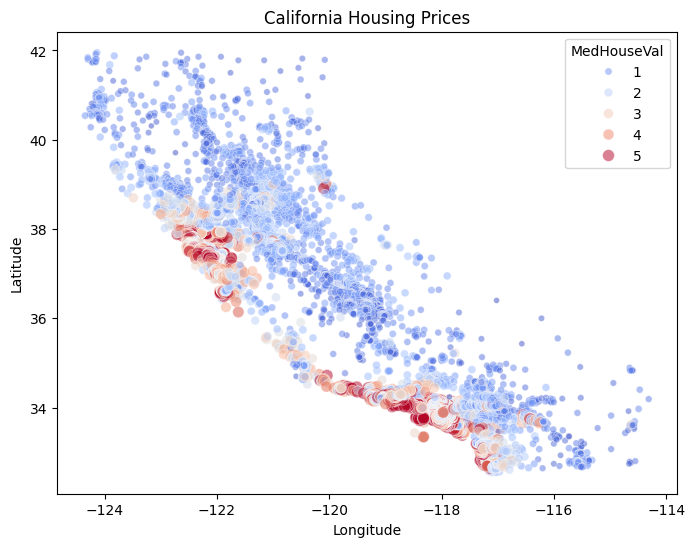

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(
  data=df,
  x='Longitude',
  y='Latitude',
  hue='MedHouseVal',
  size='MedHouseVal',
  palette='coolwarm',
  alpha=0.5,
)

plt.legend(title='MedHouseVal', loc='best')
plt.title('California Housing Prices')
plt.show()


To visualize geographic trends in California housing price (e.g. higher prices near coastal areas and urban centers, and lower prices inland), we overlay prices with the California map.

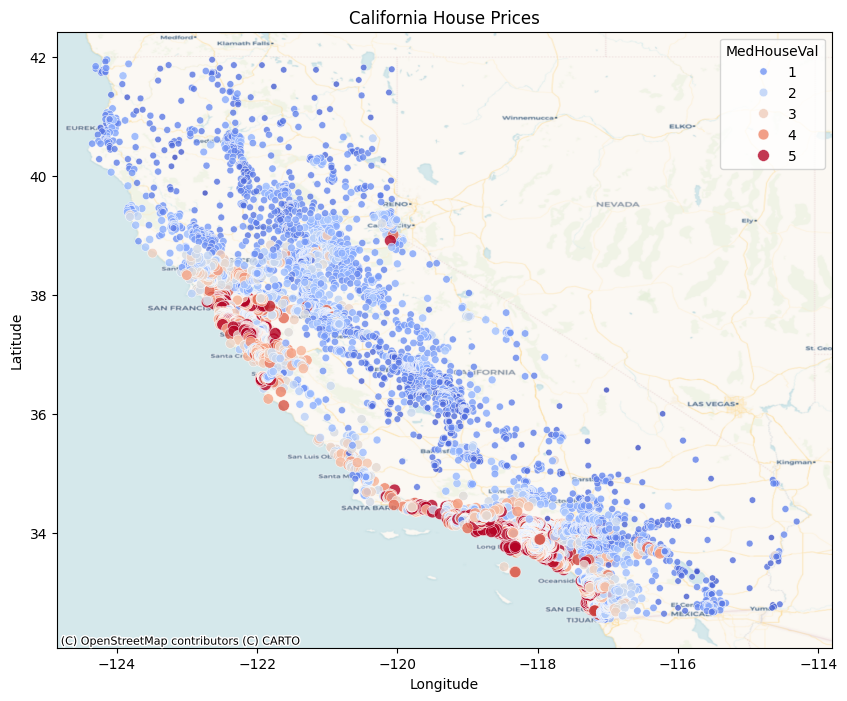

In [4]:
import contextily as ctx

plt.figure(figsize=(10, 8))
ax = plt.gca()

sns.scatterplot(
  data=df,
  x='Longitude',
  y='Latitude',
  hue='MedHouseVal',
  size='MedHouseVal',
  palette='coolwarm',
  alpha=0.8,
  ax=ax
)

## other providers
# ctx.providers.OpenStreetMap.Mapnik
# ctx.providers.CartoDB.Positron
# ctx.providers.CartoDB.Voyager
# ctx.providers.Esri.WorldImagery
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Voyager)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('California House Prices')
plt.legend(title='MedHouseVal', loc='best')
# plt.tight_layout()
plt.show()

Finally, we display results via an interactive map. The heatmap highlights areas with higher median house values, while clusters show the geographic distribution of all properties. In the heatmap, higher prices appear as warmer colors (yellow/red), lower prices as cooler colors (blue/purple) and intermediate prices as green.


In [12]:
import folium
from folium.plugins import HeatMap,FastMarkerCluster

# center map on California
m = folium.Map(location=[36.7783, -119.4179], zoom_start=6)

# coordinates
locations = df[['Latitude', 'Longitude']].values.tolist()

# prepare data for heatmap: [lat, lon, weight]
heat_data = [
  [row['Latitude'], row['Longitude'], row['MedHouseVal']]
  for _, row in df.iterrows()
]

# add heatmap layer
HeatMap(heat_data,
        radius=5,
        blur=5
).add_to(m)

# add cluster layer 
FastMarkerCluster(locations).add_to(m)

m


### Splitting data 

We partition data in training (80% of the data) to fit the model and in test set (20% of the data) to evaluate the model.

In [6]:
from sklearn.model_selection import train_test_split

X = california.data
y = california.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Predict housing prices

### Feature selection

We use [mutual information](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) to select the most relevant features for predicting house prices.

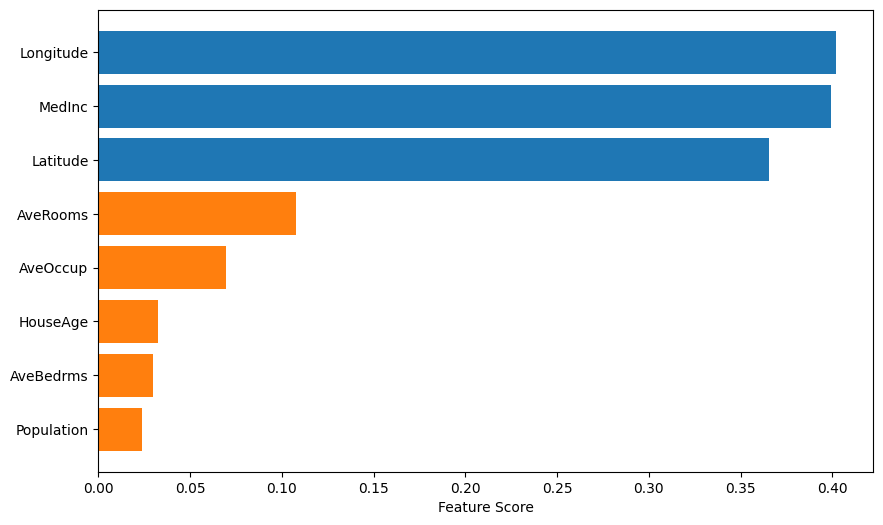

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

selector = SelectKBest(mutual_info_regression, k=3)
selector.fit(X_train, y_train)

feature_index = selector.get_support(indices=True)
all_features = X_train.columns
selected_feature = all_features[feature_index]

feature_importance = pd.DataFrame({
  'Feature': all_features,
  'Score': selector.scores_,
  'Selected': selector.get_support()
}).sort_values('Score', ascending=False)
# display(feature_importance)

plt.figure(figsize=(10, 6))
colors = ['tab:blue' if selected else 'tab:orange' for selected in feature_importance['Selected']]
plt.barh(feature_importance['Feature'], feature_importance['Score'], color=colors)
plt.xlabel('Feature Score')
plt.gca().invert_yaxis()

### Linear regression

To predict California housing prices, we train a simple linear regression model using the three most informative features identified through mutual information: median income, latitude, and longitude. This approach captures linear relationships between geographic location, income levels and housing prices. Model performance is evaluated using cross-validation and validated on a held-out test set (unseen data) to assess its generalization capability.

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

model_pipeline = Pipeline(steps=[
  ('feature_selection', SelectKBest(mutual_info_regression, k=3)),
  ('regressor', LinearRegression())
])

cv_scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(f"Cross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)

pd.DataFrame({
  "actual price": y_test,
  "predicted price": y_pred,
})

Cross-validation accuracy: -0.742 (+/- 0.024)


,actual price,predicted price
14740,1.369,2.392515
10101,2.413,2.804025
20566,2.007,1.920376
2670,0.725,0.746945
15709,4.600,2.869450
...,...,...
6655,1.695,1.552282
3505,2.046,2.369003
1919,1.286,0.939938
1450,2.595,2.968927


### Model performance

On average, the model predictions are about $75,000 away from the actual house price (RMSE: $75,163). Since the median price is $179,700, the error is quite high (relative error is about 42%).

The average absolute error (MAE) is about $55,000. This means that half of the predictions are off by less than $55,000, and half by more. MAE is less affected by large outliers than RMSE, providing a more robust measure of typical prediction error.

The model explains about 57% of the variance in house prices ($R^2$: 0.567). This is a moderate fit: the model captures more than half of the price variation, but there is still substantial unexplained variance.

In [9]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrics:")
print(f"RMSE: ${rmse*100000:.2f}")  # Multiply by 100000 since prices are in this scale
print(f"MAE: ${mae*100000:.2f}")
print(f"R²: {r2:.3f}")

Model Performance Metrics:
RMSE: $75163.22
MAE: $55266.91
R²: 0.567


## Conclusions and next step

While this linear model has moderate explanatory power, its prediction error is quite large compared to affordable house prices (for example, the 10th percentile price is $82,300). To improve performance, gradient boosting algorithms (such as XGBoost or LightGBM) could be used instead to capture complex and nonlinear relationships between features. Additionally, hyperparameter tuning using Bayesian methods - such as [hyperopt](https://hyperopt.github.io/hyperopt/) - could further enhance model performance.
